In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Introduction

We need to solve 

$$
\nabla ^2 u = f(\vec r)
$$
This reduces to 
$$
\sum _ i u_i\int \vec\nabla\phi_i(\vec r)\cdot\vec\nabla\phi_j(\vec r)d\tau  = \int f(\vec r) \phi_i(\vec r) d\tau
$$

$$
\sum _ i u_iM_{i, j}  = f_j
$$

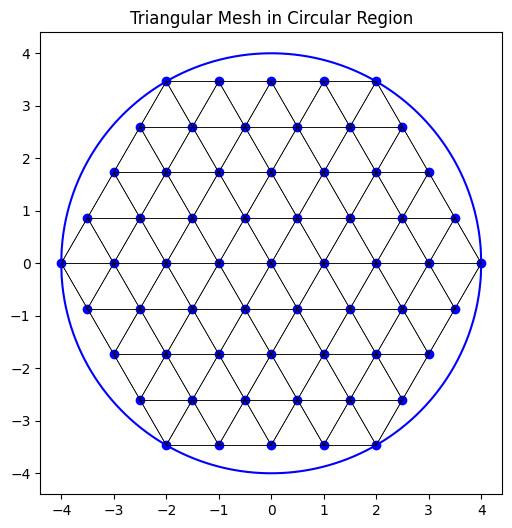

In [2]:
"""
    Define the mesh, basically the nodes and their connections, I will be assuming a triangular mesh
"""
r = 4
dr = 1
xs = np.arange(-2*r, r, dr)
mesh = []
v1, v2 = np.array([dr, 0]), np.array([dr/2, dr*np.sqrt(3)/2])
for i in range(-2*int(r/dr), 2*int(r/dr) + 1):
    for j in range(-2*int(r/dr), 2*int(r/dr) + 1):
        p = i*v1 + j*v2
        if p[0]*p[0] + p[1]*p[1] <= r*r:
            mesh.append(p)

# neigbohrs are the connected nodes
def find_triangular_neighbors(points, spacing):
    neighbors = []
    for i, point in enumerate(points):
        x1, y1 = point
        for j, other_point in enumerate(points):
            if i == j:
                continue
            x2, y2 = other_point
            # Calculate distance between the points
            dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            # If distance is approximately the spacing between neighbors, add as a neighbor
            if np.isclose(dist, spacing):
                neighbors.append((i, j))
    return neighbors

points = np.array(mesh)
neighbors=find_triangular_neighbors(points, dr)

# Plot the points and their connections (neighbors)
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], color='b')
x = np.linspace(-4, 4, 1000)
plt.plot(x, np.sqrt(16 - x*x), color='b')
plt.plot(x, -np.sqrt(16 - x*x), color='b')

# Plot the connections (edges between neighbors)
for (i, j) in neighbors:
    plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'k-', lw=0.5)

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Triangular Mesh in Circular Region")
plt.show()


In [3]:
arr = np.array([[2, 1], [6, 4], [-1, -8]])
np.sort(arr)

array([[ 1,  2],
       [ 4,  6],
       [-8, -1]])

In [79]:
def get_triangles(nodes: np.ndarray| list, connections: np.ndarray|list) ->  tuple[list, list]:
    
    # Make a list where each index i has a list of the indicies of the nodes attached to it.
    index_connections = []
    for _ in range(len(nodes)): index_connections.append([])
    for neighbor in connections: index_connections[neighbor[0]].append(neighbor[1])
    for n in index_connections: n.sort()

    
    # Find the set of triangles in the connections
    triangles = set()
    for node_index, node in enumerate(nodes): 
        for fst_neighbor in index_connections[node_index]:
            for snd_neighbor in index_connections[fst_neighbor]:
                if node_index in index_connections[snd_neighbor]:
                    triangles.add(tuple(sorted([node_index, fst_neighbor, snd_neighbor])))
    return list(triangles), index_connections

def get_triangle_area(p0: tuple[int|float, int|float] | list[int|float, int|float]| np.ndarray, 
                p1: tuple[int|float, int|float] | list[int|float, int|float]| np.ndarray,
                p2: tuple[int|float, int|float] | list[int|float, int|float]| np.ndarray) -> float:
    
    s1 = np.linalg.norm(p0 - p1)
    s2 = np.linalg.norm(p1 - p2)
    s3 = np.linalg.norm(p2 - p0)
    s  = (s1 + s2 + s3)/2
    return np.sqrt(s*(s-s1)*(s-s2)*(s-s3))


# determinant
delta = lambda i, j, k, nodes: (nodes[k][1] - nodes[i][1])*(nodes[j][0] - nodes[i][0]) - (nodes[j][1] - nodes[i][1])*(nodes[k][0] - nodes[i][0])


# Calculate the rhs vector and the matrix (M_ij) elements
from typing import Callable
def evaluate_problem(nodes: np.ndarray|list, connections: np.ndarray|list, func: Callable|list|np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    triangles, index_nbrs = get_triangles(nodes=nodes, connections=connections)
    Nn = len(nodes)
    M = np.zeros([Nn, Nn])
    F = np.zeros([Nn])
    
    for triangle in triangles:
        i, j, k = triangle
        area = get_triangle_area(nodes[i], nodes[j], nodes[k])
        if isinstance(func, Callable): f_avg = (func(nodes[i]) +func(nodes[j])+ func(nodes[k]))/3
        else: f_avg = (func[i] +func[j]+ func[k])/3
        # F[i] += f_avg*area/3
        # F[j] += f_avg*area/3
        # F[k] += f_avg*area/3
        F[i] += func[i]*area/3
        F[j] += func[j]*area/3
        F[k] += func[k]*area/3
        delta_i = delta(i, j, k, nodes)
        delta_j = delta(j, k, i, nodes)
        delta_k = delta(k, i, j, nodes)
        A_i, B_i = (nodes[j][0] - nodes[k][0])/delta_i, -(nodes[j][1] - nodes[k][1])/delta_i
        A_j, B_j = (nodes[k][0] - nodes[i][0])/delta_j, -(nodes[k][1] - nodes[i][1])/delta_j
        A_k, B_k = (nodes[i][0] - nodes[j][0])/delta_k, -(nodes[i][1] - nodes[j][1])/delta_k
        M[i, j] += (A_i*A_j + B_i*B_j)*area
        M[j, i] += (A_i*A_j + B_i*B_j)*area

        M[i, k] += (A_i*A_k + B_i*B_k)*area
        M[k, i] += (A_i*A_k + B_i*B_k)*area
        
        M[j, k] += (A_j*A_k + B_j*B_k)*area
        M[k, j] += (A_j*A_k + B_j*B_k)*area
        
        M[i, i] += (A_i*A_i + B_i*B_i)*area
        
        M[j, j] += (A_j*A_j + B_j*B_j)*area
        
        M[k, k] += (A_k*A_k + B_k*B_k)*area

        # Treat BC. phi = 0
        freq = np.zeros((len(nodes)))
        for triangle in triangles:
            for index in triangle:
                freq[index] += 1
        boundary_indicies = np.where(np.bitwise_or(freq == 2, freq == 3))[0]
        for boundary_index in boundary_indicies:
            M[boundary_index, :] = 0
            M[:, boundary_index] = 0
            M[boundary_index, boundary_index] = 100
    # for i in range(Nn):
    #     F[i] *= np.sum(f[nodes[index_nbrs[i]]])/len(index_nbrs[i])
    return M, F

In [80]:
from scipy.constants import epsilon_0

In [81]:
rhs = lambda vec: -epsilon_0*np.exp(-10*(vec[0]*vec[0] + vec[1]*vec[1]))/1000
triangles, _ = get_triangles(points, neighbors)
stiffness, f = evaluate_problem(nodes=points, connections=neighbors, func=[rhs(point) for point in points])

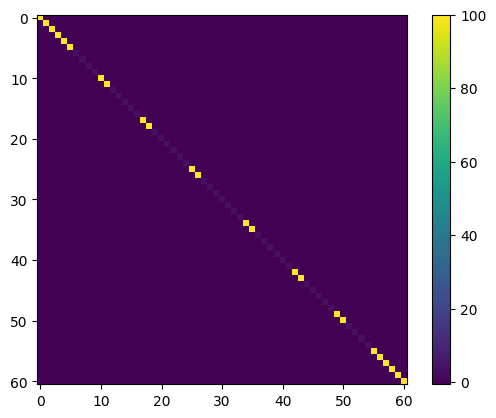

In [82]:
plt.imshow(stiffness)
plt.colorbar()
plt.show()

In [83]:
sol = np.linalg.solve(stiffness, f)

In [84]:
sol

array([-8.32608811e-87, -1.33464793e-73, -2.93975771e-69, -1.33464793e-73,
       -8.32608811e-87, -1.33464793e-73, -2.43849110e-16, -3.70650648e-16,
       -3.70650648e-16, -2.43849110e-16, -1.33464793e-73, -2.93975771e-69,
       -3.70650648e-16, -7.21793367e-16, -8.87610762e-16, -7.21793367e-16,
       -3.70650648e-16, -2.93975771e-69, -1.33464793e-73, -3.70650648e-16,
       -8.87610762e-16, -1.57038827e-15, -1.57038827e-15, -8.87610762e-16,
       -3.70650648e-16, -1.33464793e-73, -8.32608811e-87, -2.43849110e-16,
       -7.21793367e-16, -1.57038827e-15, -3.78393522e-15, -1.57038827e-15,
       -7.21793367e-16, -2.43849110e-16, -8.32608811e-87, -1.33464793e-73,
       -3.70650648e-16, -8.87610762e-16, -1.57038827e-15, -1.57038827e-15,
       -8.87610762e-16, -3.70650648e-16, -1.33464793e-73, -2.93975771e-69,
       -3.70650648e-16, -7.21793367e-16, -8.87610762e-16, -7.21793367e-16,
       -3.70650648e-16, -2.93975771e-69, -1.33464793e-73, -2.43849110e-16,
       -3.70650648e-16, -

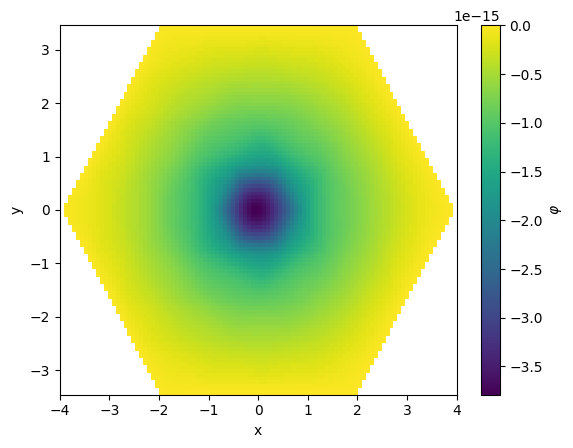

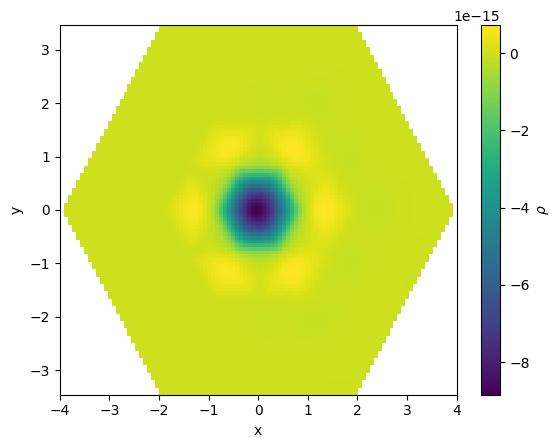

In [85]:
from scipy.interpolate import griddata
x, y = points.T
grid_x, grid_y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
grid_z = griddata((x, y), sol, (grid_x, grid_y), method='cubic')
plt.imshow(grid_z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
plt.colorbar(label=r'$\varphi$') 
plt.xlabel('x')
plt.ylabel('y')
# plt.title('Heatmap of the Function (Interpolated)')
plt.show()
grid_z2 = griddata((x, y), rhs(np.vstack([x, y])), (grid_x, grid_y), method='cubic')
plt.imshow(grid_z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
plt.colorbar(label=r'$\rho$') 
plt.xlabel('x')
plt.ylabel('y')
# plt.title('Heatmap of the Function (Interpolated)')
plt.show()

# Sparcity

In [ ]:
from scipy.sparse import coo_matrix
def evaluate_problem_sparse(nodes: np.ndarray|list, connections: np.ndarray|list, func: Callable|list|np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    triangles, index_nbrs = get_triangles(nodes=nodes, connections=connections)
    Nn = len(nodes)
    rows = []
    columns = []
    values = []
    F = np.zeros([Nn])
    
    for triangle in triangles:
        i, j, k = triangle
        area = get_triangle_area(nodes[i], nodes[j], nodes[k])
        if isinstance(func, Callable): f_avg = (func(nodes[i]) +func(nodes[j])+ func(nodes[k]))/3
        else: f_avg = (func[i] +func[j]+ func[k])/3
        F[i] += f_avg*area/3
        F[j] += f_avg*area/3
        F[k] += f_avg*area/3
        delta_i = delta(i, j, k, nodes)
        delta_j = delta(j, k, i, nodes)
        delta_k = delta(k, i, j, nodes)
        A_i, B_i = (nodes[j][0] - nodes[k][0])/delta_i, -(nodes[j][1] - nodes[k][1])/delta_i
        A_j, B_j = (nodes[k][0] - nodes[i][0])/delta_j, -(nodes[k][1] - nodes[i][1])/delta_j
        A_k, B_k = (nodes[i][0] - nodes[j][0])/delta_k, -(nodes[i][1] - nodes[j][1])/delta_k
        
        rows.append(i)
        rows.append(i)
        rows.append(j)
        rows.append(j)
        rows.append(k)
        rows.append(k)
        columns.append()
        
        M[i, j] += (A_i*A_j + B_i*B_j)*area
        M[j, i] += (A_i*A_j + B_i*B_j)*area
        M[i, k] += (A_i*A_k + B_i*B_k)*area
        M[k, i] += (A_i*A_k + B_i*B_k)*area
        M[j, k] += (A_j*A_k + B_j*B_k)*area
        M[k, j] += (A_j*A_k + B_j*B_k)*area
    # for i in range(Nn):
    #     F[i] *= np.sum(f[nodes[index_nbrs[i]]])/len(index_nbrs[i])
    return M, F

## Terminology

**NoN**: number of nodes

**NoE**: Number of Elements

**NPE**: nodes per Element

**PD**: Problem Dimension

**ENL**: Extended Node list

**NL**: Node list

**EL**: Element list

In [ ]:
NL = np.array([
    [0, 0],
    [1, 0],
    [0.5, 1],
])

EL = np.array([
    [1, 2],
    [2, 3],
    [3, 1],
])

boundaries = np.array([1, 2, 3, ])



$$
NL_{NoN \times PD} = \begin{bmatrix} 0 &0\\ 1 &0\\ 0.5 &1\end{bmatrix}
$$
each row is a node coordinate

$$
EL_{NoE \times NPE} = \begin{bmatrix}1&2\\2&3\\3&1\end{bmatrix}
$$
each row represents the indicies of nodes at edge of the element

Node 3 is pushed down by 20 N, Node 1 is fixed in both x and y, node 2 in free to move in x but not in y

Neumann: +1

Dirichlet: -1

$$
DorN_{NoN \times PD} = \begin{bmatrix} -1 &-1\\ 1 &-1\\ 1 &1\end{bmatrix}
$$


Forces matrix:
$$
F_{NoN \times PD} = \begin{bmatrix} ? & ?\\ 0 &?\\ 0 &-20\end{bmatrix}
$$


Displacement matrix:
$$
D_{NoN \times PD} = \begin{bmatrix} 0 & 0\\ ? &0\\ ? &?\end{bmatrix}
$$

In [3]:
DorN = np.array([
    [-1, -1],
    [+1, -1],
    [+1, +1]
])

F = np.array([
    [0, 0],
    [0, 0],
    [0, -20]
])

D = np.array([
    [0, 0],
    [0, 0],
    [0, 0]
])

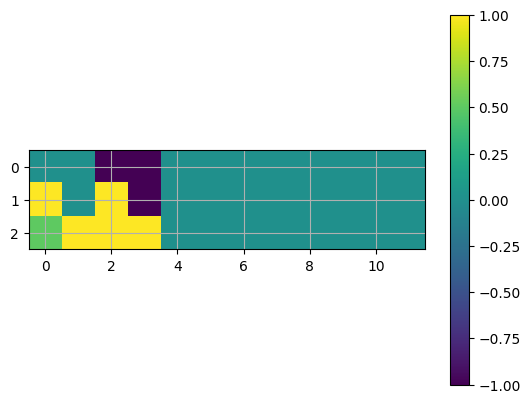

In [9]:
E = 1e6
A = 0.01
NoN, PD = NL.shape
ENL  = np.zeros([NoN, 6*PD])
ENL[:, 0:PD] = NL
ENL[:, PD:2*PD] = DorN

plt.imshow(ENL)
plt.colorbar()
plt.grid()
plt.show()

# Functions

In [5]:
def assign_BCs(NL, ENL):
    non, pd = NL.shape
    DOFs = 0 # degrees of freedom
    DOCs = 0
    # update local DOF
    for i in range(0, non):
        for j in range(0, pd):
            if ENL[i, pd+j] == -1:
                DOCs -= 1
                ENL[i, 2*pd+j] = DOCs
            else:
                DOFs += 1
                ENL[i, 2*pd + j] = DOFs
    
    for i in range(0, non):
        for j in range(0, pd):
            if ENL[i, 2*pd+j] < 0: ENL[i, 3*pd+j] = np.abs(ENL[i, 2*pd+j]) + DOFs
            else: ENL[i, 3*pd+j] = np.abs(ENL[i, 2*pd+j])

    DOCs = abs(DOCs)
    return ENL, DOFs, DOCs





In [8]:
# def assemble_stiffness(ENL, EL, NL, E, A):
#     noe, npe = EL.shape
#     non, pd = NL.shape
#     K = np.zeros([non*pd, non*pd])
#     for i in range(K.shape)

In [7]:
ENL, DOFs, DOCs = assign_BCs(NL=NL, ENL=ENL)